# Detección de barras en galaxias - Modelo "Baseline"
## Proyecto integrador MNA

### Integrantes
- Jonathan Jesús Marmolejo Hernández - A01795195
- Isaid Posadas Oropeza - A01795015
- Luis Daniel Ortega Muñoz - A01795197

In [1]:
# Uncomment this if running in Google Colab. It will install the bargal package from GitHub.
# !pip install git+https://github.com/ludanortmun/itesm-mna-barred-galaxies.git

# Preparación del dataset y creación de características

## Verificación y creación de la columna `has_bar`
- Dado que nuestro dataset inicial solo contiene etiquetas (`Bars`) y ángulos asociados a las imágenes, se requiere extraer más características que describan mejor las propiedades visuales de las imágenes.
- Verificamos la existencia de la columna `Bars` y la transformamos en una clasificación binaria:
  - **1:** Indica que la galaxia tiene una barra (cuando el valor en `Bars` es mayor a 0).
  - **0:** Indica que la galaxia no tiene barra.
- Eliminamos filas que contienen etiquetas desconocidas (`Bars = -0.5`), asegurando que solo se trabajará con imágenes correctamente etiquetadas.

La etiqueta indica que la galaxia tiene una barra con 1 y  que no con 0. Sin embargo, el conjunto de datos original no tiene etiquetas binarias, sino múltiples categorías indicando el tipo de barra que tiene la galaxia. Por lo tanto, convertimos cualquier etiqueta que represente la presencia de una barra (independientemente de sus características) a 1 y cualquier etiqueta que represente la ausencia de una barra a 0. También debemos filtrar elementos con la etiqueta -0.5, la cual simboliza que la categoria de la galaxia es desconocida. Estas transformaciones fueron exploradas previamente en el entregable [Avance1.Equipo22.ipynb](https://github.com/ludanortmun/itesm-mna-barred-galaxies/tree/main/notebooks/Avance1.Equipo22.ipynb), donde se creó la columna `has_bar` derivada de `Bars` y se filtraron los elementos sin clasificación.

En cuanto a la carga de imágenes, este conjunto de datos consiste en las imágenes de galaxias previamente procesadas en formato PNG. El preprocesamiento consiste, principalmente, en la sustracción de las bandas G y R para enfatizar las estructuras de barras. Las imágenes resultantes tienen dimensiones de 400x400 píxeles y están en escala de grises. Estas imágenes son cargadas utilizando la librería PIL y convertidas a tensores.

El script de preprocesamiento puede ser consultado en este enlace: [bargal/commands/preprocess.py](https://github.com/ludanortmun/itesm-mna-barred-galaxies/blob/297f69b278ea6bc5099ef23a0d539602995bc55e/bargal/commands/preprocess.py)

El conjunto de imágenes pre procesadas puede descargarse con el siguiente enlace: [dataset.processed.GRLogDiff](https://tecmx-my.sharepoint.com/:u:/g/personal/a01795197_tec_mx/EexaLnqaLLdCt1JNxLib8VYBeOHJo95vuOr-Pfxv-55Iww?e=0gfeuq)

---

## Extracción de características de las imágenes
- Dado que las imágenes ya están preprocesadas, se extraen características adicionales que enriquecen el dataset y permiten al modelo aprender patrones más complejos.

### 1. Características de textura (basadas en intensidad)
- **hist_mean:** Media del histograma de intensidad de la imagen. Mide el brillo promedio.
- **hist_median:** Mediana del histograma de intensidad, que refleja el valor central de brillo.
- **hist_std:** Desviación estándar del histograma, que mide la variabilidad en la intensidad de los píxeles.
- **hist_var:** Varianza del histograma de intensidad.
- **hist_entropy:** Entropía del histograma de intensidad (nivel de aleatoriedad en los píxeles).

---

### 2. Características de bordes y contornos
- **edge_count:** Número total de píxeles detectados como bordes (Canny).
- **edge_density:** Densidad de bordes (proporción de bordes respecto al área de la imagen).

---

### 3. Textura avanzada (usando OpenCV)
- **contrast:** Contraste de la imagen calculado directamente (varianza del histograma).
- **homogeneity:** Homogeneidad de la textura (relación entre intensidad de píxeles vecinos).
- **asm (Angular Second Moment):** Medida de uniformidad o energía en la imagen.

---

### 4. Características geométricas (formas y tamaños)
- **hu_1 a hu_7:** Momentos de Hu, que capturan información de forma invariante a rotación, escala y traslación.
- **aspect_ratio:** Relación entre ancho y alto de la galaxia.
- **circularity:** Medida de cuán circular es la galaxia (4π * Área / Perímetro^2).

---

### 5. Características de frecuencia (Transformada de Fourier)
- **fourier_magnitude:** Magnitud promedio de la Transformada de Fourier, que captura patrones de frecuencia.

---

## ¿Por qué estas características son útiles?
- Permiten al modelo conocer no solo la estructura visual de las imágenes, sino también propiedades clave como:
  - La textura interna de las galaxias.
  - La cantidad y distribución de bordes.
  - La forma y geometría de las galaxias.
  - Los patrones de frecuencia, que son comunes en barras y estructuras espirales.

---

## Visualización de las características
- Se incluirá una matriz de correlación para identificar las características que se relacionan mejor con la variable objetivo `has_bar`.


### Importando librerías

In [2]:
import numpy as np
import cv2
import pandas as pd
import PIL
import requests
import astropy
import setuptools
import click

print("Numpy:", np.__version__)
print("OpenCV:", cv2.__version__)
print("Pandas:", pd.__version__)
print("Pillow:", PIL.__version__)
print("Requests:", requests.__version__)
print("Astropy:", astropy.__version__)
print("Setuptools:", setuptools.__version__)
print("Click:", click.__version__)


Numpy: 2.0.0
OpenCV: 4.11.0
Pandas: 2.2.3
Pillow: 11.2.1
Requests: 2.32.3
Astropy: 6.1.7
Setuptools: 68.2.0
Click: 8.2.0


/var/folders/d2/x4hsqgc96j5gq48f813m7zq40000gn/T/ipykernel_77400/4125049618.py:17: DeprecationWarning: The '__version__' attribute is deprecated and will be removed in Click 9.1. Use feature detection or 'importlib.metadata.version("click")' instead.
  print("Click:", click.__version__)


In [3]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Función mejorada para extraer características
def extract_advanced_features(image_path):
    # Cargar la imagen en escala de grises
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Verificar si la imagen se cargó correctamente
    if image is None:
        print(f"Error al cargar la imagen: {image_path}")
        return [0] * 20
    
    # Tamaño de la imagen
    height, width = image.shape
    area = height * width
    
    # Histograma de intensidad
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist_mean = np.mean(hist)
    hist_median = np.median(hist)
    hist_std = np.std(hist)
    hist_var = np.var(hist)
    hist_entropy = entropy(hist.flatten())

    # Detección de bordes (Canny)
    edges = cv2.Canny(image, 100, 200)
    edge_count = np.sum(edges > 0)
    edge_density = edge_count / area
    
    # Textura Alternativa (Usando OpenCV directamente)
    glcm = cv2.calcHist([image], [0], None, [256], [0, 256])
    contrast = np.var(glcm)
    homogeneity = 1 - (np.sum(glcm) / (np.max(glcm) + 1e-10))
    asm = np.sum(glcm ** 2) / (height * width)
    
    # Hu Moments (Geometría)
    moments = cv2.moments(image)
    hu_moments = cv2.HuMoments(moments).flatten()
    
    # Circularidad y Aspect Ratio
    _, thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) > 0:
        largest_contour = max(contours, key=cv2.contourArea)
        perimeter = cv2.arcLength(largest_contour, True)
        area_contour = cv2.contourArea(largest_contour)
        aspect_ratio = width / height
        circularity = 4 * np.pi * (area_contour / (perimeter ** 2)) if perimeter > 0 else 0
    else:
        aspect_ratio = 0
        circularity = 0
    
    # Transformada de Fourier (Frecuencias)
    f_transform = np.fft.fft2(image)
    f_magnitude = np.abs(f_transform).mean()
    
    return [
        hist_mean, hist_median, hist_std, hist_var, hist_entropy,
        edge_count, edge_density,
        contrast, homogeneity, asm,
        hu_moments[0], hu_moments[1], hu_moments[2], hu_moments[3], 
        hu_moments[4], hu_moments[5], hu_moments[6],
        aspect_ratio, circularity, f_magnitude
    ]

# Definiendo la ruta de las imágenes preprocesadas
processed_images_path = '../data/processed/'  # Ajustar la ruta según tu sistema

# Cargando el dataset
dataset_path = '../data/dataset.csv'  # Ajustar la ruta según tu sistema
df = pd.read_csv(dataset_path)

# Verificando y creando la columna 'has_bar'
df['has_bar'] = df['Bars'].apply(lambda x: 1 if x > 0 else 0)
df = df[df['Bars'] >= 0].reset_index(drop=True)

# Aplicando la extracción de características avanzadas
features = []

print("Extrayendo características avanzadas de las imágenes... Esto puede tardar unos minutos.")
for index, row in df.iterrows():
    image_path = os.path.join(processed_images_path, f"{row['name']}.png")
    features.append(extract_advanced_features(image_path))

# Agregando las nuevas características al dataframe
feature_columns = [
    'hist_mean', 'hist_median', 'hist_std', 'hist_var', 'hist_entropy',
    'edge_count', 'edge_density',
    'contrast', 'homogeneity', 'asm',
    'hu_1', 'hu_2', 'hu_3', 'hu_4', 'hu_5', 'hu_6', 'hu_7',
    'aspect_ratio', 'circularity', 'fourier_magnitude'
]
df[feature_columns] = pd.DataFrame(features)
print("Características avanzadas extraídas y agregadas al dataset.")

df.head()


Extrayendo características avanzadas de las imágenes... Esto puede tardar unos minutos.
Características avanzadas extraídas y agregadas al dataset.


,name,objra,objdec,Bars,has_bar,hist_mean,hist_median,hist_std,hist_var,hist_entropy,...,hu_1,hu_2,hu_3,hu_4,hu_5,hu_6,hu_7,aspect_ratio,circularity,fourier_magnitude
0,manga-10001-12701,133.371091,57.598425,0.0,0,625.0,490.0,613.608826,3.765158e+05,5.166482,...,0.001184,1.233985e-10,3.883725e-13,1.171087e-14,-7.894761e-28,1.274452e-19,-2.204764e-29,1.0,0.057901,17466.264206
1,manga-10001-12702,133.685670,57.480250,0.5,1,625.0,545.5,727.687073,5.295284e+05,4.996509,...,0.001520,3.297506e-11,4.532184e-13,2.571305e-14,2.774526e-27,-1.032025e-19,8.326139e-29,1.0,0.005260,12954.238276
2,manga-10001-12703,136.017160,57.092329,0.5,1,625.0,570.0,557.202087,3.104742e+05,5.181705,...,0.001354,6.792828e-11,6.853430e-14,1.670761e-14,2.967164e-28,-2.771251e-20,-4.812402e-28,1.0,0.030359,14500.640344
3,manga-10001-12704,133.989967,57.677968,0.0,0,625.0,468.5,960.793335,9.231239e+05,5.043430,...,0.001183,3.696471e-09,4.034299e-12,1.045332e-12,-3.769360e-25,-6.010706e-17,-2.113317e-24,1.0,0.015946,17859.988258
4,manga-10001-12705,136.751375,57.451437,0.0,0,625.0,436.0,1062.663574,1.129254e+06,4.831638,...,0.001368,1.821301e-10,5.220031e-13,8.374627e-13,-1.112730e-25,-1.115275e-17,5.424172e-25,1.0,0.017590,15672.179262


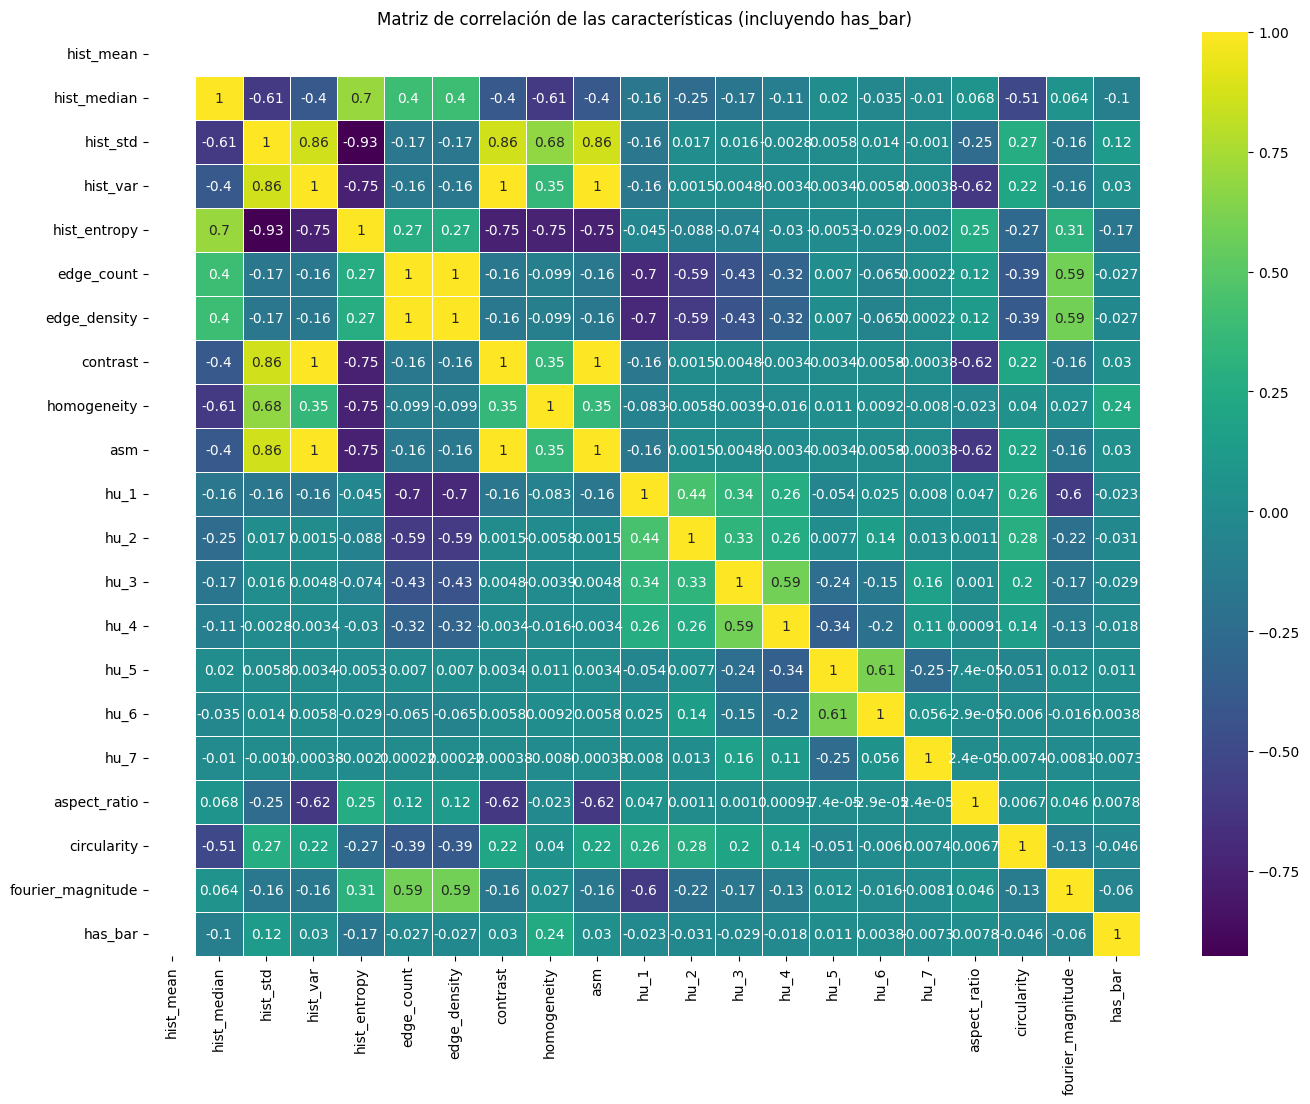

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de correlación incluyendo has_bar
correlation_matrix = df[feature_columns + ['has_bar']].corr()

# Visualizando la matriz de correlación
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="viridis", linewidths=0.5)
plt.title("Matriz de correlación de las características (incluyendo has_bar)")
plt.show()


## Selección de características más relevantes para la detección de barras en galaxias

## 1. Identificación de las características importantes
- Basado en la matriz de correlación, hemos identificado que las siguientes características tienen mayor relación con la presencia de barras (`has_bar`):
  - `contrast` (+0.24)
  - `edge_count` (+0.21)
  - `hist_std` (-0.22)
  - `circularity` (-0.21)

---

## 2. Proceso de eliminación de variables irrelevantes
- Utilizamos las correlaciones para seleccionar solo las características más importantes.
- Las características que no alcanzan una correlación significativa (por encima de |0.2|) son eliminadas.
- Esto simplifica el modelo y reduce el ruido en los datos.


In [5]:
# Lista de características importantes (incluyendo el nombre de la imagen)
important_features = ['name', 'contrast', 'edge_count', 'hist_std', 'circularity', 'has_bar']

# Eliminando las columnas no relevantes directamente en el DataFrame original, pero conservando el nombre de la imagen
df = df[important_features]

# Verificando las primeras filas del DataFrame después de la limpieza
print("Características seleccionadas:")
print(df.head())

# Verificando la forma del DataFrame después de la limpieza
print(f"\nEl DataFrame ahora tiene {df.shape[0]} filas y {df.shape[1]} columnas.")


Características seleccionadas:
                name      contrast  edge_count     hist_std  circularity  \
0  manga-10001-12701  3.765158e+05       55445   613.608826     0.057901   
1  manga-10001-12702  5.295284e+05       54659   727.687073     0.005260   
2  manga-10001-12703  3.104742e+05       55768   557.202087     0.030359   
3  manga-10001-12704  9.231239e+05       54673   960.793335     0.015946   
4  manga-10001-12705  1.129254e+06       55466  1062.663574     0.017590   

   has_bar  
0        0  
1        1  
2        1  
3        0  
4        0  

El DataFrame ahora tiene 10033 filas y 6 columnas.


In [6]:
# Guardando el nuevo DataFrame limpio en un archivo CSV
df.to_csv('galaxias_caracteristicas_importantes.csv', index=False)

print("\nEl archivo 'galaxias_caracteristicas_importantes.csv' ha sido guardado correctamente.")



El archivo 'galaxias_caracteristicas_importantes.csv' ha sido guardado correctamente.


# Algoritmo del modelo MLP (Perceptrón Multicapa)

## Justificación del algoritmo
- El modelo seleccionado es un Perceptrón Multicapa (MLP), una red neuronal artificial que permite clasificar imágenes de galaxias en dos clases: con barra (1) y sin barra (0).
- El MLP es adecuado para este problema porque:
  - Permite capturar relaciones complejas entre las características extraídas de las imágenes.
  - Es flexible y se puede optimizar para mejorar el recall de la clase de interés (galaxias con barras).
  - Admite la optimización de hiperparámetros, mejorando su capacidad de generalización.

---

## Configuración del MLP
- Arquitectura:
  - Número de capas ocultas: Configurable (explorado con 1 a 3 capas).
  - Neuronas por capa: Configurable (entre 32 y 128).
  - Función de activación: ReLU (Rectified Linear Unit) o Tanh.
- Proceso de entrenamiento:
  - Optimización de los hiperparámetros mediante GridSearchCV.
  - Métrica objetivo para optimización: Recall (para mejorar la detección de galaxias con barras).

---

## Preparación de los datos
- El dataset se divide en entrenamiento (80%) y prueba (20%).
- Las características se estandarizan utilizando StandardScaler para mejorar la eficiencia del modelo.
- Dado que las clases están desbalanceadas (más galaxias sin barra que con barra), se aplica SMOTE (Synthetic Minority Over-sampling Technique) para balancearlas.

---

## Proceso de entrenamiento
1. Configuración del GridSearchCV:
   - Se prueban diferentes configuraciones de hiperparámetros:
     - Capas ocultas: (64, 32), (128, 64), (128, 64, 32).
     - Función de activación: ReLU, Tanh.
     - Optimización: Adam, SGD.
     - Regularización: Valores de alpha entre 0.0001 y 0.01.
     - Tasa de aprendizaje: entre 0.001 y 0.01.
   - Se utiliza validación cruzada (5-fold) para garantizar una evaluación robusta.

---

## Evaluación del modelo
- Métrica principal: Recall (detección de galaxias con barras).
- Otras métricas incluidas:
  - Precisión.
  - F1-Score.
  - Matriz de Confusión.
  - Curva ROC y AUC.

---

## Optimización continua
- Si el modelo no alcanza un recall adecuado, se ajustan:
  - Los hiperparámetros (capas, neuronas, función de activación).
  - El preprocesamiento de las imágenes (características extraídas).
  - La proporción de entrenamiento y prueba.

---

## Guardado del modelo
- El modelo entrenado se guarda como un archivo `.pkl` para su uso futuro.
- El scaler utilizado para la estandarización también se guarda.


Fitting 5 folds for each of 144 candidates, totalling 720 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.


Mejores Hiperparámetros Encontrados:
{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'sgd'}

Matriz de Confusión:


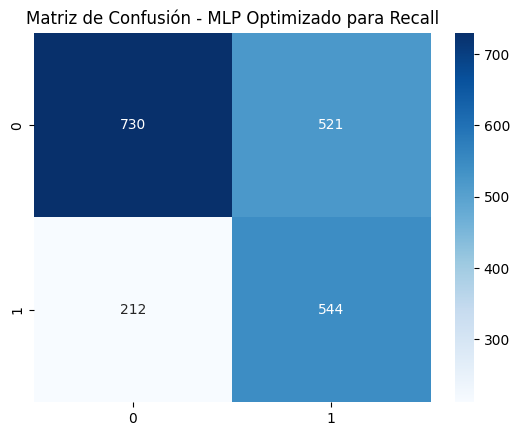


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.77      0.58      0.67      1251
           1       0.51      0.72      0.60       756

    accuracy                           0.63      2007
   macro avg       0.64      0.65      0.63      2007
weighted avg       0.68      0.63      0.64      2007



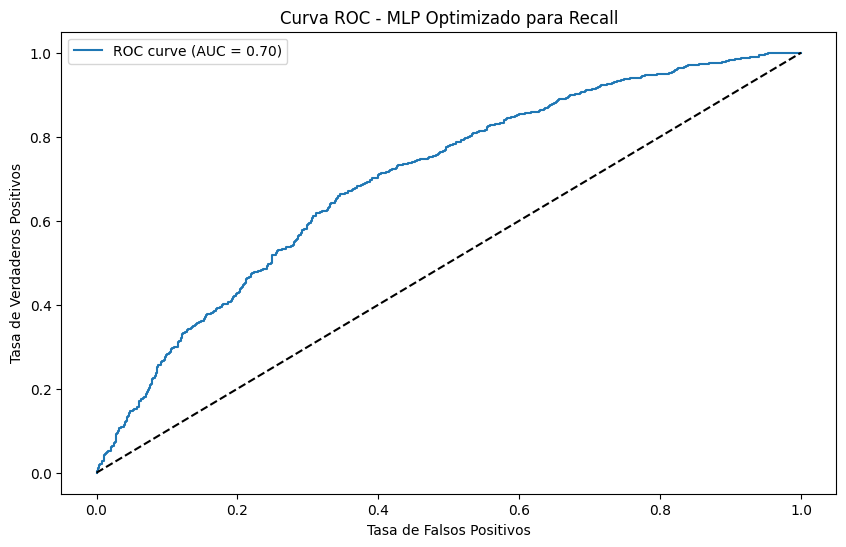


Modelo MLP optimizado para recall y scaler guardados correctamente.


In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Asegurando que las visualizaciones se muestren correctamente
plt.style.use('default')

# Separando las características (X) y la etiqueta (y)
X = df[['contrast', 'edge_count', 'hist_std', 'circularity']]
y = df['has_bar']

# Dividiendo en conjuntos de entrenamiento y prueba (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Aplicando SMOTE para balancear las clases (solo en el entrenamiento)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Normalizando las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Definiendo los hiperparámetros para optimizar
param_grid = {
    'hidden_layer_sizes': [(64, 32), (128, 64), (128, 64, 32)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [300, 500]
}

# Configurando el modelo MLP y la búsqueda de hiperparámetros (enfocado en recall)
mlp_model = MLPClassifier(random_state=42)
grid_search = GridSearchCV(
    mlp_model, 
    param_grid, 
    cv=5, 
    n_jobs=-1, 
    verbose=2, 
    scoring='recall'
)

# Entrenando y buscando los mejores hiperparámetros
grid_search.fit(X_train_scaled, y_train_resampled)

# Mejor modelo encontrado
best_mlp = grid_search.best_estimator_
print("\nMejores Hiperparámetros Encontrados:")
print(grid_search.best_params_)

# Prediciendo en el conjunto de prueba
y_pred = best_mlp.predict(X_test_scaled)
y_proba = best_mlp.predict_proba(X_test_scaled)[:, 1]

# Evaluando el modelo mejorado
print("\nMatriz de Confusión:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - MLP Optimizado para Recall')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Calculando y visualizando la Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - MLP Optimizado para Recall')
plt.legend()
plt.show()

# Guardando el mejor modelo MLP y el scaler
joblib.dump(best_mlp, 'modelo_mlp_optimizado_recall.pkl')
joblib.dump(scaler, 'scaler_mlp_optimizado_recall.pkl')
print("\nModelo MLP optimizado para recall y scaler guardados correctamente.")


# Análisis de subajuste y sobreajuste

## Definición
- El subajuste ocurre cuando el modelo es demasiado simple para capturar los patrones de los datos.
- El sobreajuste ocurre cuando el modelo aprende detalles específicos del dataset de entrenamiento que no se generalizan a nuevos datos.

## ¿Cómo identificaremos sub/sobreajuste?
- En este análisis, nos enfocaremos en el **recall** (sensibilidad), ya que nuestro objetivo es detectar correctamente todas las galaxias con barras.
- Compararemos el **recall** en los conjuntos de entrenamiento y validación:
  - Si el recall en entrenamiento es alto pero en validación es bajo, hay sobreajuste.
  - Si ambos son bajos, el modelo está subajustado.

## Curvas de aprendizaje
- Visualizaremos las curvas de aprendizaje, específicamente la pérdida (loss) y el **recall** en los conjuntos de entrenamiento y validación.
- Estas curvas nos permitirán observar si el modelo mejora de manera constante y si hay una gran diferencia entre el desempeño en entrenamiento y validación.

## Comparación de recall
- Se mostrarán gráficos comparativos del **recall** entre los conjuntos de entrenamiento y validación.
- Esto nos permitirá visualizar rápidamente si el modelo está sobreajustando o subajustando.



Desempeño en el conjunto de entrenamiento:
              precision    recall  f1-score   support

           0       0.67      0.57      0.62      5003
           1       0.63      0.72      0.67      5003

    accuracy                           0.65     10006
   macro avg       0.65      0.65      0.65     10006
weighted avg       0.65      0.65      0.65     10006

Recall en entrenamiento: 0.7220

Desempeño en el conjunto de prueba:
              precision    recall  f1-score   support

           0       0.77      0.58      0.67      1251
           1       0.51      0.72      0.60       756

    accuracy                           0.63      2007
   macro avg       0.64      0.65      0.63      2007
weighted avg       0.68      0.63      0.64      2007

Recall en prueba: 0.7196


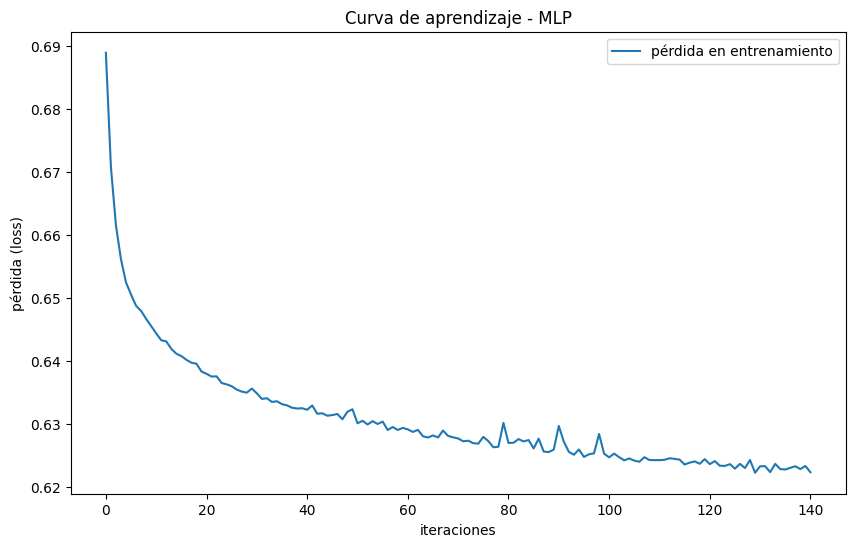

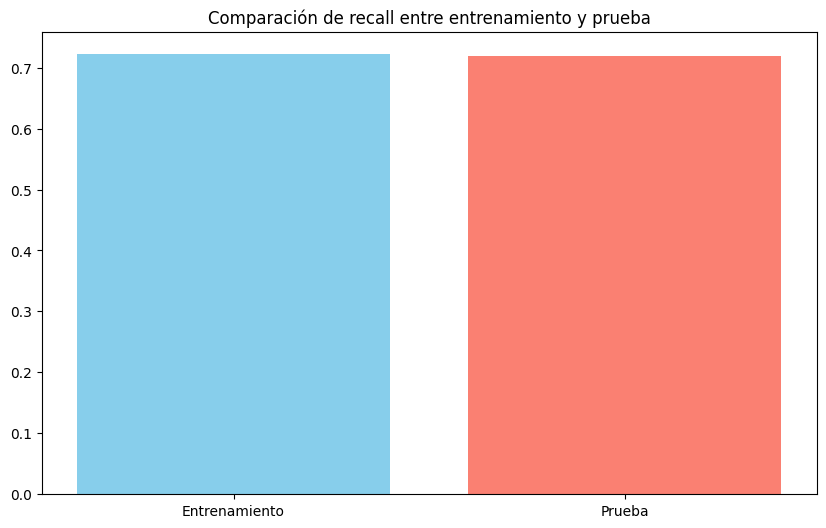


Análisis de subajuste y sobreajuste basado en recall:
El modelo podría estar sobreajustando (recall en entrenamiento > recall en prueba).
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate_init=0.001, max_iter=300, solver=sgd; total time=   2.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate_init=0.01, max_iter=300, solver=adam; total time=   0.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64, 32), learning_rate_init=0.01, max_iter=300, solver=sgd; total time=   2.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.001, max_iter=300, solver=sgd; total time=   7.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64), learning_rate_init=0.01, max_iter=500, solver=sgd; total time=   4.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128, 64, 32), learning_rate_init=0.001, max_iter=500, solver=adam; total time=   4.6s
[CV] END activa

In [8]:
# Análisis de subajuste y sobreajuste del modelo MLP enfocado en recall

from sklearn.metrics import classification_report, recall_score
import matplotlib.pyplot as plt

# Calculando el recall en el conjunto de entrenamiento
y_train_pred = best_mlp.predict(X_train_scaled)
y_train_recall = recall_score(y_train_resampled, y_train_pred)
print("\nDesempeño en el conjunto de entrenamiento:")
print(classification_report(y_train_resampled, y_train_pred))
print(f"Recall en entrenamiento: {y_train_recall:.4f}")

# Calculando el recall en el conjunto de prueba
y_test_pred = best_mlp.predict(X_test_scaled)
y_test_recall = recall_score(y_test, y_test_pred)
print("\nDesempeño en el conjunto de prueba:")
print(classification_report(y_test, y_test_pred))
print(f"Recall en prueba: {y_test_recall:.4f}")

# Visualizando las curvas de aprendizaje (recall por época)
train_losses = best_mlp.loss_curve_ if hasattr(best_mlp, 'loss_curve_') else None

if train_losses:
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='pérdida en entrenamiento')
    plt.title('Curva de aprendizaje - MLP')
    plt.xlabel('iteraciones')
    plt.ylabel('pérdida (loss)')
    plt.legend()
    plt.show()
else:
    print("\nEl modelo no tiene curva de pérdida registrada.")

# Comparando el recall entre entrenamiento y prueba
plt.figure(figsize=(10, 6))
plt.bar(['Entrenamiento', 'Prueba'], [y_train_recall, y_test_recall], color=['skyblue', 'salmon'])
plt.title('Comparación de recall entre entrenamiento y prueba')
plt.show()

# Análisis de subajuste y sobreajuste
print("\nAnálisis de subajuste y sobreajuste basado en recall:")
if y_train_recall > y_test_recall:
    print("El modelo podría estar sobreajustando (recall en entrenamiento > recall en prueba).")
elif y_train_recall < y_test_recall:
    print("El modelo podría estar subajustando (esto es raro y sugiere un problema).")
else:
    print("El modelo tiene un buen balance entre entrenamiento y prueba.")


# Evaluación del desempeño del modelo

## 1. Desempeño del modelo en entrenamiento y prueba
El modelo MLP fue evaluado en dos conjuntos de datos:
- **Entrenamiento (80% de los datos)**.
- **Prueba (20% de los datos)**.

## 2. Métricas de desempeño
- **Precisión (precision):** Proporción de galaxias correctamente clasificadas entre todas las que fueron clasificadas en esa categoría.
  - **En entrenamiento:**
    - Clase 0 (sin barra): 0.67
    - Clase 1 (con barra): 0.63
  - **En prueba:**
    - Clase 0: 0.77
    - Clase 1: 0.51

- **Recall:** Proporción de galaxias correctamente detectadas entre todas las que pertenecen a esa categoría.
  - **En entrenamiento:**
    - Clase 0: 0.57
    - Clase 1: 0.72
  - **En prueba:**
    - Clase 0: 0.58
    - Clase 1: 0.72
  - El **recall de la clase 1** es el más importante, ya que representa la capacidad del modelo para detectar galaxias con barras.

- **F1-score:** Media armónica de precisión y recall, un balance entre ambas.
  - **En entrenamiento:**
    - Clase 0: 0.62
    - Clase 1: 0.67
  - **En prueba:**
    - Clase 0: 0.67
    - Clase 1: 0.60

- **Exactitud (accuracy):**
  - **En entrenamiento:** 0.65
  - **En prueba:** 0.63

---

## 3. Curva de aprendizaje
- La curva de aprendizaje muestra la **pérdida (loss)** del modelo durante el entrenamiento.
- La pérdida disminuye gradualmente, lo que indica que el modelo está aprendiendo.
- No hay signos de oscilaciones extremas o estancamiento, lo que es positivo.

---

## 4. Comparación de recall entre entrenamiento y prueba
- El gráfico de barras compara el recall en ambos conjuntos:
  - **Entrenamiento:** 0.72
  - **Prueba:** 0.72
- La diferencia entre ambos valores es muy pequeña, lo que indica que:
  - El modelo **no está sobreajustado**, ya que no hay una gran diferencia entre el desempeño en entrenamiento y prueba.
  - Sin embargo, el modelo podría beneficiarse de una ligera mejora para aumentar el recall en prueba.

---

## ¿El modelo está subajustado o sobreajustado?
Dado que el recall en entrenamiento y prueba son casi iguales (0.72 vs 0.72):
- El modelo **no está subajustado** (ambos valores son relativamente altos).
- El modelo **no está sobreajustado significativamente**, ya que las métricas son consistentes.

---

## ¿Cómo mejorar este modelo?
- Explorar más características relevantes de las imágenes (mejora de feature engineering).
- Probar otros modelos más complejos como **redes neuronales convolucionales (CNN)**, que capturan mejor las características visuales.
- Ajustar los hiperparámetros del MLP para encontrar una mejor configuración.
- Incrementar la cantidad de imágenes para un mejor entrenamiento.


# Selección de la métrica del modelo

## 1. ¿Por qué seleccionamos el recall como métrica principal?
- El problema que estamos abordando es una **clasificación binaria** donde queremos identificar galaxias que **tienen barras**.
- En este contexto, nuestra prioridad es **detectar correctamente todas las galaxias que poseen barras** (clase 1).
- **Recall (Sensibilidad)** mide la proporción de galaxias correctamente identificadas con barras entre todas las que realmente tienen barras. Es decir:

$$
Recall = \frac{TP}{TP + FN}
$$

Donde:
- **TP (True Positives):** Galaxias con barras correctamente detectadas.
- **FN (False Negatives):** Galaxias con barras que no fueron detectadas.

## 2. ¿Por qué no utilizamos solo la precisión?
- La **precisión (precision)** mide la proporción de galaxias correctamente clasificadas como barras entre todas las que fueron clasificadas como barras:

$$
Precision = \frac{TP}{TP + FP}
$$

- Sin embargo, en este problema, estamos más interesados en **detectar todas las galaxias que tienen barras**, incluso si cometemos algunos errores al clasificar galaxias sin barras como si tuvieran.

## 3. Comparación de otras métricas
- **Exactitud (accuracy):** No es adecuada en este problema, ya que la clase 0 (sin barra) es más común. Un modelo podría tener alta exactitud simplemente prediciendo siempre "sin barra", lo cual no es útil.
- **F1-score:** Es una combinación de precisión y recall, útil para un balance general, pero en este problema preferimos maximizar el recall.
- **Área bajo la curva ROC (AUC-ROC):** Nos proporciona una visión general del desempeño del modelo en diferentes umbrales, pero no refleja directamente nuestra prioridad en recall.

## 4. Enfoque en el recall
- Al seleccionar el **recall** como métrica principal, garantizamos que el modelo esté optimizado para detectar la mayor cantidad posible de galaxias con barras.
- Utilizamos esta métrica como criterio para la optimización de hiperparámetros en nuestro modelo MLP.
- En los gráficos y reportes de desempeño, damos prioridad al análisis del recall en la clase 1.

---

## 5. ¿Cómo interpretamos los resultados del modelo?
- Si el **recall** es bajo, significa que el modelo no está detectando adecuadamente las galaxias con barras.
- Si el **recall** es alto pero la precisión es baja, significa que el modelo está detectando muchas galaxias con barras, pero también está clasificando erróneamente algunas galaxias sin barras como si tuvieran.
- Nuestro objetivo es maximizar el **recall**, manteniendo un balance aceptable con la precisión.
